<a href="https://colab.research.google.com/github/VectorBw/Data-science/blob/master/Deploy_on_the_web.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 - Deploy a neural network in a web site

We will create a simple tool that recognizes drawings and outputs the names of the current drawing. This app will run directly on the browser without any installations. We will use Google Colab for training the model, and we will deploy it on the browser using TensorFlow.js.

This assignment is heavily inspired from [this article](https://medium.com/tensorflow/train-on-google-colab-and-run-on-the-browser-a-case-study-8a45f9b1474e).
As always, we analyse it:
- there is an obvious improvement: we can solve the problem of memory exhaustion. There are at least 2 solutions:
    - Instead of loading all the images in memory (which is quite stupid, because it requires a lot of memory !!), we could use Keras' [ImageDataGenerator](https://keras.io/preprocessing/image/) and its function flow_from_directory() to load only the few images required for each iteration of the learning process. But if we did that, we would face another problem: the training would become very slow, because each individual file would be fetched from disk.
    - Or simply load small parts of the dataset in memory, train the network on this part, load another small part, improve the training, and so on... In this notebook, we take that solution.
- that problem being solved, we can use the full dataset of 345 classes, not only a subset of 100 of them. The drawback, as you will see, is that many drawings are unclear, and some classes can easily be mixed with other ones. Therefore, the accuracy won't be better than 70%.

Moreover, we deploy the website directly from Colaboratory. No need for anything else, which is much easier than in the article.

![Texte alternatif…](https://cdn-images-1.medium.com/max/800/1*Xbvo-Diilbltp3AEgtTOig.gif)

##Download the dataset
We will use a CNN to recognize drawings of different types. The CNN will be trained on the [Quick Draw dataset](https://github.com/googlecreativelab/quickdraw-dataset). The dataset contains around 50 million drawings of 345 classes.

![Texte alternatif…](https://cdn-images-1.medium.com/max/800/1*kMEmKip2dqTQPX4m9Nt8gQ.png)

In [0]:
DATA_DIRECTORY = "data"

!mkdir {DATA_DIRECTORY}

First we download the dataset from Google Cloud Storage. It is opensourced by Google; we simply have to follow the [instructions](https://cloud.google.com/storage/docs/access-public-data)

In [0]:
# Save the names of the files that we want to download, into a file called list_files.txt
!gsutil ls -r gs://quickdraw_dataset/full/numpy_bitmap > list_files.txt

In [0]:
# Load the list in memory
with open("list_files.txt","r") as mini_classes:  
  classes = mini_classes.readlines() 

In [0]:
# The file names are like 'gs://quickdraw_dataset/full/numpy_bitmap/The Eiffel Tower.npy\n' , 
# but we want to keep only 'The Eiffel Tower', so we need to suppress the other caracters
#classes = # YOUR CODE HERE
for i in range(len(classes)):
  classes[i] = classes[i].replace("gs://quickdraw_dataset/full/numpy_bitmap/","")
  classes[i] = classes[i].replace(".npy\n","")
  print(classes[i])

:

The Eiffel Tower
The Great Wall of China
The Mona Lisa
aircraft carrier
airplane
alarm clock
ambulance
angel
animal migration
ant
anvil
apple
arm
asparagus
axe
backpack
banana
bandage
barn
baseball bat
baseball
basket
basketball
bat
bathtub
beach
bear
beard
bed
bee
belt
bench
bicycle
binoculars
bird
birthday cake
blackberry
blueberry
book
boomerang
bottlecap
bowtie
bracelet
brain
bread
bridge
broccoli
broom
bucket
bulldozer
bus
bush
butterfly
cactus
cake
calculator
calendar
camel
camera
camouflage
campfire
candle
cannon
canoe
car
carrot
castle
cat
ceiling fan
cell phone
cello
chair
chandelier
church
circle
clarinet
clock
cloud
coffee cup
compass
computer
cookie
cooler
couch
cow
crab
crayon
crocodile
crown
cruise ship
cup
diamond
dishwasher
diving board
dog
dolphin
donut
door
dragon
dresser
drill
drums
duck
dumbbell
ear
elbow
elephant
envelope
eraser
eye
eyeglasses
face
fan
feather
fence
finger
fire hydrant
fireplace
firetruck
fish
flamingo
flashlight
flip flops
floor lamp
flower
fly

In [0]:
classes.remove(":\n")

In [0]:
classes

['The Eiffel Tower',
 'The Great Wall of China',
 'The Mona Lisa',
 'aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball bat',
 'baseball',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 '

In [0]:
nb_classes = len(classes)
nb_classes

345


##Load the Data
Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.

In [0]:
# We download the images, which have been saved as numpy arrays
# NB: each file contains many images: it is an array of gray scale images, ie. an array of shape [nb_images, 28, 28, 1]
# where each image is 28x28 pixels, gray scale.
import urllib.request
def download(class_file):
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  cls_url = class_file.replace(' ', '%20')
  path = base+cls_url+'.npy'
  print(path)
  # We download the file in the directory 'data'
  urllib.request.urlretrieve(path, DATA_DIRECTORY + '/'+class_file+'.npy')

In [0]:
classes[0]

'The Eiffel Tower'

In [0]:
# Test with the first class
download(classes[0])

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/The%20Eiffel%20Tower.npy


In [0]:
# As explained here: https://github.com/googlecreativelab/quickdraw-dataset#numpy-bitmaps-npy ,
# this dataset contains 28x28 gray scale images
IMG_SIZE = 28

# The dataset is too big for the memory of the Colaboratory virtual machine.
# Therefore, we load only the NB_EXAMPLES_BY_CLASS of each class
NB_EXAMPLES_BY_CLASS = 1000

TEST_RATIO = 0.10

In [0]:
import os
import glob
import numpy as np

# Loads in memory max_items_per_class samples of the class classe, by starting at index start_index
def load_class(classe, start_index = 0, max_items_per_class= None ):  
  
    #load each data file 
    data = np.load( os.path.join(DATA_DIRECTORY, classe + '.npy') )
    stop_index = len(data)
    if max_items_per_class is not None:
        stop_index = min(stop_index, start_index + max_items_per_class)
    # Take the subset of data starting at index start_index, stopping at index stop_index
    # You could use array slicing
    data = data[start_index:stop_index]

    return data


In [0]:
# Test with the first class
x_tmp_0 = load_class(classes[0], 0, max_items_per_class=NB_EXAMPLES_BY_CLASS)
x_tmp_0[24].shape

(784,)

In [0]:
import cv2
from random import randint
import matplotlib.pyplot as plt

# Show one random example of class class_file
def show_one_random_image(x_train):
  
  # Select a random index in x_train
  idx = randint(0, len(x_train))
  # Visualize the image x_train[idx]
  # As x_train[idx] is a vector of length 728, you first need to reshape it to a matrix of shape (IMG_SIZE,IMG_SIZE)
  # After that, you could use plt.imshow() in order to visualize it
  # YOUR CODE HERE 
  print(idx)
  #x_train[idx] = x_train[idx].reshape(IMG_SIZE,IMG_SIZE)
  print(x_train[idx].shape)
  img = plt.imshow(x_train[idx].reshape(IMG_SIZE,IMG_SIZE))
  plt.show()
 

846
(784,)


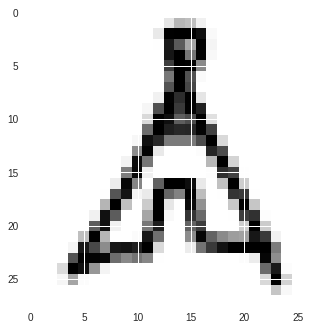

In [0]:
# You should call this function several times. You will see that people are drawing things
# on very different ways.
# Therefore, this dataset is much more difficult than MNIST, where the images of the numbers 
# are quite similar.
show_one_random_image(x_tmp_0)

Now that the above functions work, we can download the full dataset

In [0]:

# Now that the previous function are working, we download and convert the full dataset
for idx, classe in enumerate(classes):
  download(classe)


https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/The%20Eiffel%20Tower.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/The%20Great%20Wall%20of%20China.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/The%20Mona%20Lisa.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/aircraft%20carrier.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/alarm%20clock.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ambulance.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/angel.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/animal%20migration.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ant.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_b

##Define the neural network

Here is an architecture that works:
- convolution2D, 16 filters of size 3x3, padding 'same', activation 'relu'
- maxPool2D of size 2x2
- convolution2D, 32 filters of size 3x3, padding 'same', activation 'relu'
- maxPool2D of size 2x2
- convolution2D, 64 filters of size 3x3, padding 'same', activation 'relu'
- maxPool2D of size 2x2
- dense layer with 1000 neurons, activation 'relu'
- dense layer for the output

   * Don't forget to flatten the output of the last maxpool layer, before the first dense layer

HOW MANY NEURONS MUST THE LAST LAYER HAVE ?

As we need to do classification over many classes:
- which activation function must we use in the last layer ?
- which loss function must we use ?

USE THE METRIC top_k_categorical_accuracy INSTEAD OF THE USUAL accuracy. WHAT DOES THAT METRIC DO ?

In [0]:
import keras as keras
from keras import layers
from keras import optimizers
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense


# Define model
model = keras.Sequential()
# YOUR CODE HERE
model.add(Conv2D(16, (3, 3), padding="same", input_shape=(28,28,1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
          
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())          
model.add(Dense(1000, activation="relu"))         

model.add(Dense(345, activation="softmax"))    
          
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["top_k_categorical_accuracy"])          
          
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
__________

##Train the network

Iterate over the classes and load them with load_class().
Store the images in a array called x, and the labels in an array called y

In [0]:

def load_data(start_index = 0, max_items_per_class= None ):
  
  #initialize variables 
  x = np.empty([0, 784])
  y = np.empty([0])

  for idx, classe in enumerate(classes):
    # Load max_items_per_class samples of the class classe, starting at start_index
    data = load_class(classe, start_index = start_index, max_items_per_class= max_items_per_class)
    # The label of this class is idx (the index of the class in the list of classes)
    # As you need to label each sample of data, you have to create a vector of that size,
    # filled with that label idx
    labels = np.full(data.shape[0],idx)# YOUR CODE HERE. Hint: use np.full() in order to create a vector of size data.shape[0] that you fill with idx

    x = np.concatenate((x, data), axis=0)
    y = np.append(y, labels)
    
  
  #randomize the dataset 
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]
    
  return x,y


Train the network into a loop which:
- loads the next NB_EXAMPLES_BY_CLASS in memory
- reshapes the images to [IMG_SIZE, IMG_SIZE, 1] arrays
- normalizes the images
- one-hot-encodes the labels
- improves the training of the neural network on that subset

You can limit the training to the first 20.000 samples of each class. According to my tests, the results improve very slightly if you add more.

In [0]:

from tensorflow.python.keras.callbacks import EarlyStopping

stop_after_2_bad_epochs = EarlyStopping(monitor='val_loss', patience=2)

for i in range(20000 // NB_EXAMPLES_BY_CLASS):
    start_index = i * NB_EXAMPLES_BY_CLASS
    print('Loading index ' + str(start_index) + '. Be patient, it will take a while before the training begins.')
    # Load NB_EXAMPLES_BY_CLASS samples, starting at index start_index
    x_train, y_train = load_data(start_index = start_index, max_items_per_class= NB_EXAMPLES_BY_CLASS) # YOUR CODE HERE
    
    # Reshape and normalize
    x_train = x_train.reshape(x_train.shape[0], IMG_SIZE, IMG_SIZE, 1).astype('float32')

    # What is the easiest way to normalize images ?
    x_train = x_train/255# YOUR CODE HERE

    # one-hot-encode y_train and y_test, using keras.utils.to_categorical()
    y_train = keras.utils.to_categorical(y_train,nb_classes) # YOUR CODE HERE
    #y_test = keras.utils.to_categorical(y_test,nb_classes)# YOUR CODE HERE
    
    # Launch the training by calling model.fit()
    # Use validation_split=0.1 , so that 10% of the data will be used as a validation set
    # Use a batch size of 256, 50 epochs, and the callback stop_after_2_bad_epochs in order to stop
    # before overfitting
    # YOUR CODE HERE
    model.fit(x_train, y_train, validation_split=0.1, batch_size=256, epochs=50,verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=2)])


Loading index 0. Be patient, it will take a while before the training begins.
Train on 310500 samples, validate on 34500 samples
Epoch 1/50
310500/310500 [==============================] - 275s 886us/step - loss: 2.9624 - top_k_categorical_accuracy: 0.6162 - val_loss: 2.2781 - val_top_k_categorical_accuracy: 0.7487
Epoch 2/50
310500/310500 [==============================] - 122s 394us/step - loss: 2.0532 - top_k_categorical_accuracy: 0.7830 - val_loss: 2.0090 - val_top_k_categorical_accuracy: 0.7920
Epoch 3/50
310500/310500 [==============================] - 107s 345us/step - loss: 1.7990 - top_k_categorical_accuracy: 0.8211 - val_loss: 1.9063 - val_top_k_categorical_accuracy: 0.8086
Epoch 4/50
310500/310500 [==============================] - 80s 259us/step - loss: 1.6387 - top_k_categorical_accuracy: 0.8425 - val_loss: 1.8572 - val_top_k_categorical_accuracy: 0.8153
Epoch 5/50
310500/310500 [==============================] - 82s 265us/step - loss: 1.5142 - top_k_categorical_accuracy: 

In [0]:
model.save( 'DL-TP2.h5')

##Prepare the application for your smartphone
We convert the model to a JSON file compatible with TensorFlowJS

![Texte alternatif…](https://cdn-images-1.medium.com/max/800/1*i2S-d3c-NcFxCnUhNd_Wfg.png)

In [0]:
!wget http://www.eyrignoux.com.fr/coursIA/deepLearning/DL-TP2.h5

--2018-11-29 00:14:45--  http://www.eyrignoux.com.fr/coursIA/deepLearning/DL-TP2.h5
Resolving www.eyrignoux.com.fr (www.eyrignoux.com.fr)... 62.210.16.62
Connecting to www.eyrignoux.com.fr (www.eyrignoux.com.fr)|62.210.16.62|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11393776 (11M)
Saving to: ‘DL-TP2.h5.1’

DL-TP2.h5.1         100%[===================>]  10.87M  10.5MB/s    in 1.0s    

2018-11-29 00:14:47 (10.5 MB/s) - ‘DL-TP2.h5.1’ saved [11393776/11393776]



In [0]:
!git clone https://github.com/zaidalyafeai/zaidalyafeai.github.io.git

Cloning into 'zaidalyafeai.github.io'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 6997 (delta 33), reused 0 (delta 0), pack-reused 6936
Receiving objects: 100% (6997/6997), 2.01 GiB | 28.48 MiB/s, done.
Resolving deltas: 100% (3433/3433), done.
Checking out files: 100% (771/771), done.


In [0]:
WEB_DIRECTORY = "/content/zaidalyafeai.github.io/sketcher"
MODEL_WEB_DIRECTORY = WEB_DIRECTORY + "/model2"

In [0]:
!rm {MODEL_WEB_DIRECTORY + "/*"}

In [0]:
with open( MODEL_WEB_DIRECTORY + '/class_names.txt', 'w') as file_handler:
    for item in classes:
        file_handler.write("{}\n".format(item))

In [0]:
!pip install tensorflowjs

    100% |████████████████████████████████| 307kB 5.5MB/s 
    100% |████████████████████████████████| 13.9MB 2.2MB/s 
    100% |████████████████████████████████| 51kB 19.8MB/s 
tensorflow 1.12.0 has requirement keras-applications>=1.0.6, but you'll have keras-applications 1.0.4 which is incompatible.
tensorflow 1.12.0 has requirement keras-preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.2 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Found existing installation: Keras-Applications 1.0.6
    Uninstalling Keras-Applications-1.0.6:
      Successfully uninstalled Keras-Applications-1.0.6
  Found existing installation: Keras-Preprocessing 1.0.5
    Uninstalling Keras-Preprocessing-1.0.5:
      Successfully uninstalled Keras-Preprocessing-1.0.5
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4


In [0]:

!tensorflowjs_converter --input_format keras DL-TP2.h5 {MODEL_WEB_DIRECTORY + "/"}

Using TensorFlow backend.


##Open a http tunnel so that you can reach the web application from your smartphone
We are going to start a HTTP server inside the VM, but it won't be visible from outside.

Therefore, we first need to open a tunnel that you can call with your smartphone or any other device.


In [0]:
!git clone https://github.com/mixuala/colab_utils.git

Cloning into 'colab_utils'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 65.93 KiB | 1.40 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [0]:

import colab_utils.tboard

DIR_GROK = '/content/tmp'
!mkdir {DIR_GROK}
colab_utils.tboard.install_ngrok(DIR_GROK)

mkdir: cannot create directory ‘/content/tmp’: File exists
ngrok installed


In [0]:
HTTP_PORT = 8081
get_ipython().system_raw('{}/ngrok http {} &'.format(DIR_GROK, HTTP_PORT))

In [0]:
# get webapp url
# BUG: getting connection refused for HTTPConnectionPool(host='localhost', port=4040)
#     on first run, retry works
import time
import requests 

time.sleep(3)
retval = requests.get('http://localhost:4040/api/tunnels')
webapp_url = retval.json()['tunnels'][0]['public_url'].strip()
print("webapp url=", webapp_url)

webapp url= http://ca0b8035.ngrok.io


##Start the web server
WARNING: if you stop it, the VM gets killed as well, and you have to restart it

In [0]:
import http.server
import socketserver
import os

os.chdir(WEB_DIRECTORY)

Handler = http.server.SimpleHTTPRequestHandler

with socketserver.TCPServer(("", HTTP_PORT), Handler) as httpd:
    print("serving at port", HTTP_PORT)
    httpd.serve_forever()

serving at port 8081


127.0.0.1 - - [29/Nov/2018 00:26:27] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2018 00:26:27] "GET /pie.css HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2018 00:26:27] "GET /main.css HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2018 00:26:27] "GET /fabric.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2018 00:26:28] "GET /main.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2018 00:26:28] "GET /pie.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2018 00:26:29] "GET /model2/model.json HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2018 00:26:29] "GET /model2/group1-shard1of1 HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2018 00:26:30] code 404, message File not found
127.0.0.1 - - [29/Nov/2018 00:26:30] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [29/Nov/2018 00:26:31] "GET /model2/class_names.txt HTTP/1.1" 200 -
